## Perceptron

In [1]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels: ', np.unique(y))

Class labels:  [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=114, stratify=y)

In [3]:
print(f'Labels count in y: {np.bincount(y)}')
print(f'Labels count in y_train: {np.bincount(y_train)}')
print(f'Labels count in y_test: {np.bincount(y_test)}')

Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=114)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=114)

In [6]:
y_pred = ppn.predict(X_test_std)
print(f'Misclassified examples: {(y_test != y_pred).sum()}')

Misclassified examples: 2


In [7]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.96


In [8]:
print(f'Accuracy: {ppn.score(X_test_std, y_test):.2f}')

Accuracy: 0.96


In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

<ipython-input-9-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


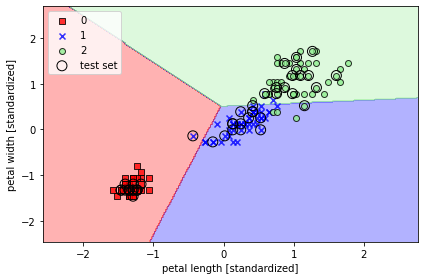

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Logistic Regression

In [11]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

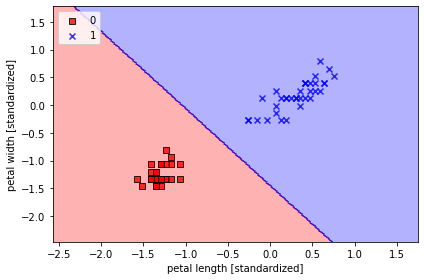

In [12]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=514)
lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-9-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


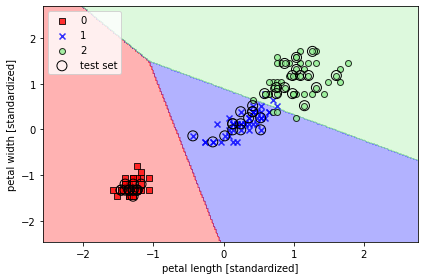

In [13]:
from sklearn.linear_model import LogisticRegression

lr_ovr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr_ovr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=lr_ovr,
                     test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-9-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


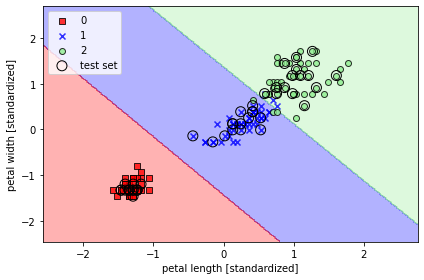

In [14]:
lr_multinomial = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='multinomial')
lr_multinomial.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=lr_multinomial,
                     test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
lr_ovr.predict_proba(X_test_std[:3])

array([[3.07819226e-04, 9.93918473e-01, 5.77370814e-03],
       [7.60934267e-04, 9.96342640e-01, 2.89642596e-03],
       [4.85492620e-04, 9.97443092e-01, 2.07141509e-03]])

In [16]:
lr_ovr.predict(X_test_std[:3])

array([1, 1, 1])

In [17]:
lr_ovr.predict(X_test_std[0].reshape(1, -1))

array([1])

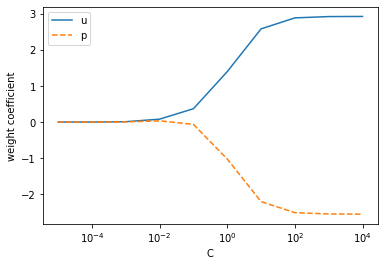

In [18]:
weights, params = [], []

for c in np.arange(-5, 5):
    lr = LogisticRegression(
        C=10. ** c,
        random_state=1,
        solver='lbfgs',
        multi_class='ovr'
    )
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10. ** c)
    
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.xlabel('C')
plt.ylabel('weight coefficient')
plt.legend('upper left')
plt.xscale('log')
plt.show()

## Support Vector Machine

<ipython-input-9-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


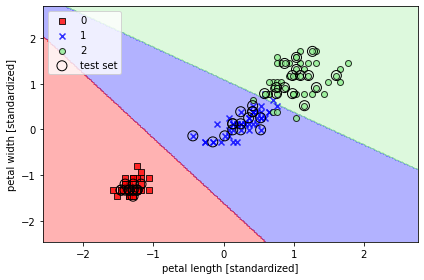

In [19]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-9-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


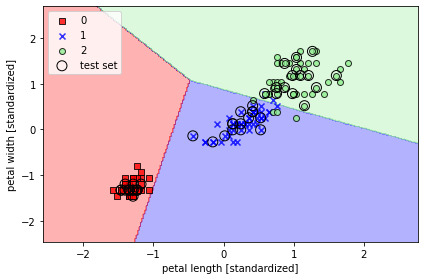

In [22]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='hinge')
ppn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Kernel SVM

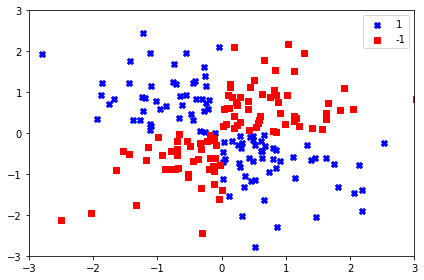

In [23]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='b', marker='X', label='1')
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], c='r', marker='s', label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

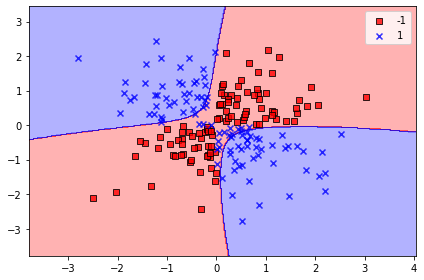

In [31]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10.0)
svm.fit(X_xor, y_xor)

plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

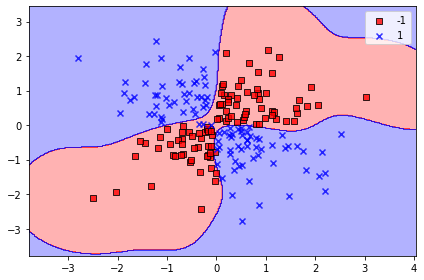

In [34]:
svm = SVC(kernel='rbf', random_state=1, gamma=1.0, C=10.0)
svm.fit(X_xor, y_xor)

plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

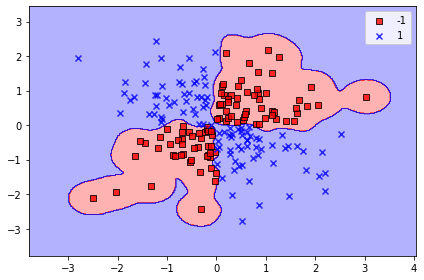

In [35]:
svm = SVC(kernel='rbf', random_state=1, gamma=10.0, C=10.0)
svm.fit(X_xor, y_xor)

plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<ipython-input-9-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


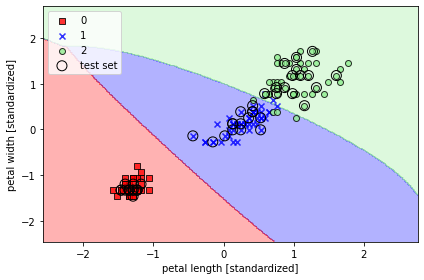

In [36]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-9-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


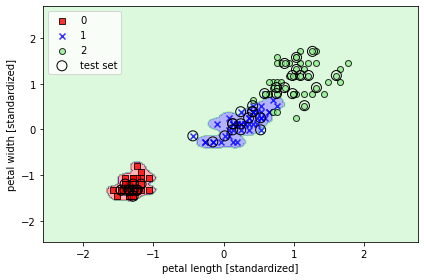

In [37]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Decision Tree